In [33]:
import os
import cv2 as cv
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from keras_facenet import FaceNet
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from tensorflow.keras.models import Model
from scipy.spatial.distance import cosine
import tensorflow as tf

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device name: {details['device_name']}")
else:
    print("No GPU devices found")

Device name: NVIDIA GeForce RTX 3060 Laptop GPU


# FaceNet

In [28]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []  
        self.Y = []  
        mp_face_detection = mp.solutions.face_detection
        mp_drawing = mp.solutions.drawing_utils
        self.detector = mp_face_detection.FaceDetection(min_detection_confidence=0.9)
        self.embedder = FaceNet()  
        
    def extract_face(self, img):
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        faces = self.detector.process(img_rgb)
        if faces.detections:
            bboxC = faces.detections[0].location_data.relative_bounding_box
            x, y, w, h = int(bboxC.xmin * img.shape[1]), int(bboxC.ymin * img.shape[0]), int(bboxC.width * img.shape[1]), int(bboxC.height * img.shape[0])
            face = img_rgb[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        else:
            return None

    def load_faces(self, video_path):
        cap = cv.VideoCapture(video_path)
        frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count - 1, num=30, dtype=np.int32)

        extracted_faces = []
        for idx in frame_indices:
            cap.set(cv.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                face = self.extract_face(frame)
                if face is not None:
                    extracted_faces.append(face)
        
        cap.release()
        return extracted_faces

    def compute_embeddings(self, faces):
        faces = np.array(faces)
        faces = faces.astype('float32')
        embeddings = self.embedder.embeddings(faces)
        return embeddings

    def load_classes(self):
        all_embeddings = []
        for video_name in os.listdir(self.directory):
            base_name = os.path.splitext(video_name)[0]
            video_path = os.path.join(self.directory, video_name)
            faces = self.load_faces(video_path)
            if faces:
                embeddings = self.compute_embeddings(faces)
                labels = [base_name for _ in range(len(faces))]
                print(f"Loaded successfully: {len(labels)} frames from {video_name}")
                self.X.extend(faces)
                self.Y.extend(labels)
                all_embeddings.extend(embeddings)
        
        return np.asarray(self.X), np.asarray(self.Y), np.asarray(all_embeddings)

    def plot_images(self):
        plt.figure(figsize=(18, 16))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')

In [29]:
face_loader = FACELOADING(directory='Dataset/Final/Enroll')
X, Y, embeddings = face_loader.load_classes()
#face_loader.plot_images()
#plt.show()

Loaded successfully: 30 frames from Chris Evans.mp4
Loaded successfully: 30 frames from Evangeline Lilly.mp4
Loaded successfully: 30 frames from Jamie Foxx.mp4
Loaded successfully: 30 frames from Keira Knightley.mp4
Loaded successfully: 30 frames from Nicole Kidman.mp4
Loaded successfully: 30 frames from Randall Park.mp4
Loaded successfully: 30 frames from Ryan Reynolds.mp4
Loaded successfully: 30 frames from Scarlett Johansson.mp4
Loaded successfully: 30 frames from Will Ferrell.mp4
Loaded successfully: 30 frames from Will Smith.mp4


In [30]:
np.savez_compressed('faces_embeddings_done.npz', EMBEDDED_X=embeddings, Y=Y)

In [6]:
# Load known embeddings and labels
data = np.load('faces_embeddings_done.npz')
known_embeddings = data['EMBEDDED_X']
known_labels = data['Y']

# Initialize face detector and embedder
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
detector = mp_face_detection.FaceDetection(min_detection_confidence=0.9)
embedder = FaceNet()

In [7]:
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]

def recognize_face(embedding, known_embeddings, known_labels, face_threshold=0.4):
    distances = [cosine(embedding, known_emb) for known_emb in known_embeddings]
    min_distance = min(distances)
    if min_distance < face_threshold:
        index = distances.index(min_distance)
        return known_labels[index]
    else:
        return 'Unknown'

def process_video(video_path, face_threshold=0.4, display=False):
    cap = cv.VideoCapture(video_path)
    
    # Extract the video filename from the path
    video_filename = video_path.split('/')[-1] 

    known_frames = 0
    unknown_frames = 0 

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        # Perform face detection and get embeddings
        faces = detector.process(img_rgb)

        if faces.detections:
            for detection in faces.detections:
                bboxC = detection.location_data.relative_bounding_box
                x, y, bw, bh = bboxC.xmin, bboxC.ymin, bboxC.width, bboxC.height
                h, w, _ = frame.shape

                # Convert to pixel values
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x, y = max(0, x), max(0, y)

                face_img = img_rgb[y:y+bh, x:x+bw]
                face_resized = cv.resize(face_img, (160, 160))

                # Get embedding and recognize face
                embedding = get_embedding(face_resized)
                label = recognize_face(embedding, known_embeddings, known_labels, face_threshold)

                if label == 'Unknown':
                    unknown_frames += 1
                else:
                    known_frames += 1

                if display:
                    color = (0, 0, 255) if label == 'Unknown' else (0, 255, 0)
                    cv.rectangle(frame, (x, y), (x+bw, y+bh), color, 2)
                    cv.putText(frame, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        if display:
            cv.putText(frame, f'Playing: {video_filename}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv.imshow('Face Recognition', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
    
    cap.release()
    if display:
        cv.destroyAllWindows()
    
    face_prediction = "Known" if known_frames >= unknown_frames else "Unknown"
    final_prediction = face_prediction
    print(f"The video '{video_filename}' is classified as '{final_prediction}'")

    return final_prediction

In [8]:
video_path = r'C:\Users\Ivan\Desktop\FaceNet\Dataset\Final\Fake\DFL_1_HQ.mp4'
process_video(video_path, face_threshold=0.4, display=True)

The video 'C:\Users\Ivan\Desktop\FaceNet\Dataset\Final\Fake\DFL_1_HQ.mp4' is classified as 'Known'


'Known'

In [30]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 1,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "FaceNet"   

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    face_threshold=thresh,
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Unknown" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'Final\Fake\DFL_1_HQ.mp4' is classified as 'Unknown'
System: FaceNet, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_1_LQ.mp4' is classified as 'Unknown'
System: FaceNet, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_2_HQ.mp4' is classified as 'Unknown'
System: FaceNet, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_2_LQ.mp4' is classified as 'Unknown'
System: FaceNet, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_3_HQ.mp4' is classified as 'Unknown'
System: FaceNet, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_3_LQ.mp4' is classified as 'Unknown'
System: FaceNet, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_4_HQ.mp4' is classified as 'Unknown'
System: FaceNet, Threshold: 0.00, Video:

EER: 0.420 at threshold 0.20


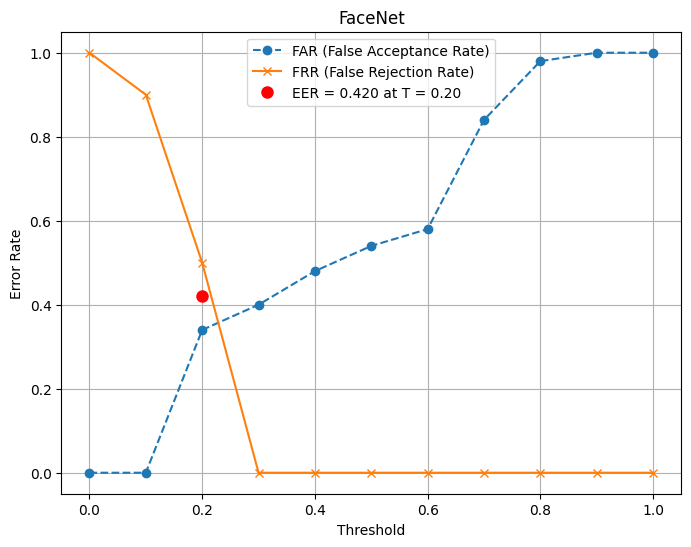

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


csv_path = "Dataset/Results/FaceNet_results.csv"
df = pd.read_csv(csv_path)

thresholds = np.sort(df['threshold'].unique())

far_list = []
frr_list = []

for thresh in thresholds:
    df_thresh = df[df['threshold'] == thresh]
    
    gt = df_thresh['gt'].values
    pred = df_thresh['prediction'].values

    fake_count = np.sum(gt == 1)
    false_accepts = np.sum((gt == 1) & (pred == 0))
    far = false_accepts / fake_count if fake_count > 0 else 0

    genuine_count = np.sum(gt == 0)
    false_rejects = np.sum((gt == 0) & (pred == 1))
    frr = false_rejects / genuine_count if genuine_count > 0 else 0

    far_list.append(far)
    frr_list.append(frr)

far_arr = np.array(far_list)
frr_arr = np.array(frr_list)

abs_diff = np.abs(far_arr - frr_arr)
eer_index = np.argmin(abs_diff)
eer_threshold = thresholds[eer_index]
eer_value = (far_arr[eer_index] + frr_arr[eer_index]) / 2  

print(f"EER: {eer_value:.3f} at threshold {eer_threshold:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, far_arr, label='FAR (False Acceptance Rate)', linestyle='--', marker='o')
plt.plot(thresholds, frr_arr, label='FRR (False Rejection Rate)', linestyle='-', marker='x')
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("FaceNet")
plt.grid(True)

plt.plot(eer_threshold, eer_value, 'ro', markersize=8, 
         label=f"EER = {eer_value:.3f} at T = {eer_threshold:.2f}")
plt.legend()

plt.show()

# VGG Face

In [36]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (224, 224)
        self.X = []  
        self.Y = []  
        mp_face_detection = mp.solutions.face_detection
        mp_drawing = mp.solutions.drawing_utils
        self.detector = mp_face_detection.FaceDetection(min_detection_confidence=0.9)
        base_model = VGGFace(model='vgg16', include_top=True)  
        self.embedder = Model(inputs=base_model.input, outputs=base_model.get_layer('fc6').output)   
        
    def extract_face(self, img):
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        faces = self.detector.process(img_rgb)
        if faces.detections:
            bboxC = faces.detections[0].location_data.relative_bounding_box
            x, y, w, h = int(bboxC.xmin * img.shape[1]), int(bboxC.ymin * img.shape[0]), int(bboxC.width * img.shape[1]), int(bboxC.height * img.shape[0])
            face = img_rgb[y:y+h, x:x+w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        else:
            return None

    def load_faces(self, video_path):
        cap = cv.VideoCapture(video_path)
        frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, frame_count - 1, num=30, dtype=np.int32)

        extracted_faces = []
        for idx in frame_indices:
            cap.set(cv.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                face = self.extract_face(frame)
                if face is not None:
                    extracted_faces.append(face)
        
        cap.release()
        return extracted_faces

    def compute_embeddings(self, faces):
        faces = np.array(faces, dtype='float32')
        faces = preprocess_input(faces, version=1)  
        embeddings = self.embedder.predict(faces)
        return embeddings

    def load_classes(self):
        all_embeddings = []
        for video_name in os.listdir(self.directory):
            base_name = os.path.splitext(video_name)[0]
            video_path = os.path.join(self.directory, video_name)
            faces = self.load_faces(video_path)
            if faces:
                embeddings = self.compute_embeddings(faces)
                labels = [base_name for _ in range(len(faces))]
                print(f"Loaded successfully: {len(labels)} frames from {video_name}")
                self.X.extend(faces)
                self.Y.extend(labels)
                all_embeddings.extend(embeddings)
        
        return np.asarray(self.X), np.asarray(self.Y), np.asarray(all_embeddings)

    def plot_images(self):
        plt.figure(figsize=(18, 16))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')

In [37]:
face_loader = FACELOADING(directory='Dataset/Final/Enroll')
X, Y, embeddings = face_loader.load_classes()

Loaded successfully: 30 frames from Chris Evans.mp4
Loaded successfully: 30 frames from Evangeline Lilly.mp4
Loaded successfully: 30 frames from Jamie Foxx.mp4
Loaded successfully: 30 frames from Keira Knightley.mp4
Loaded successfully: 30 frames from Nicole Kidman.mp4
Loaded successfully: 30 frames from Randall Park.mp4
Loaded successfully: 30 frames from Ryan Reynolds.mp4
Loaded successfully: 30 frames from Scarlett Johansson.mp4
Loaded successfully: 30 frames from Will Ferrell.mp4
Loaded successfully: 30 frames from Will Smith.mp4


In [38]:
np.savez_compressed('faces_embeddings_done.npz', EMBEDDED_X=embeddings, Y=Y)

In [39]:
# Load known embeddings and labels
data = np.load('faces_embeddings_done.npz')
known_embeddings = data['EMBEDDED_X']
known_labels = data['Y']

# Initialize face detector and embedder
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
detector = mp_face_detection.FaceDetection(min_detection_confidence=0.9)
base_model = VGGFace(model='vgg16', include_top=True) 
embedder = Model(inputs=base_model.input, outputs=base_model.get_layer('fc6').output)  

In [40]:
def get_embedding(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    face_img = preprocess_input(face_img, version=1)  

    embedding = embedder.predict(face_img)
    return embedding[0]

def recognize_face(embedding, known_embeddings, known_labels, face_threshold=0.4):
    distances = [cosine(embedding, known_emb) for known_emb in known_embeddings]
    min_distance = min(distances)
    if min_distance < face_threshold:
        index = distances.index(min_distance)
        return known_labels[index]
    else:
        return 'Unknown'

def process_video(video_path, face_threshold=0.4, display=False):
    cap = cv.VideoCapture(video_path)
    
    # Extract the video filename from the path
    video_filename = video_path.split('/')[-1] 

    known_frames = 0
    unknown_frames = 0 

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        img_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

        # Perform face detection and get embeddings
        faces = detector.process(img_rgb)

        if faces.detections:
            for detection in faces.detections:
                bboxC = detection.location_data.relative_bounding_box
                x, y, bw, bh = bboxC.xmin, bboxC.ymin, bboxC.width, bboxC.height
                h, w, _ = frame.shape

                # Convert to pixel values
                x, y, bw, bh = int(x * w), int(y * h), int(bw * w), int(bh * h)
                x, y = max(0, x), max(0, y)

                face_img = img_rgb[y:y+bh, x:x+bw]
                face_resized = cv.resize(face_img, (224, 224))

                # Get embedding and recognize face
                embedding = get_embedding(face_resized)
                label = recognize_face(embedding, known_embeddings, known_labels, face_threshold)

                if label == 'Unknown':
                    unknown_frames += 1
                else:
                    known_frames += 1

                if display:
                    color = (0, 0, 255) if label == 'Unknown' else (0, 255, 0)
                    cv.rectangle(frame, (x, y), (x+bw, y+bh), color, 2)
                    cv.putText(frame, label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        
        if display:
            cv.putText(frame, f'Playing: {video_filename}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv.imshow('Face Recognition', frame)
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
    
    cap.release()
    if display:
        cv.destroyAllWindows()
    
    face_prediction = "Known" if known_frames >= unknown_frames else "Unknown"
    final_prediction = face_prediction
    print(f"The video '{video_filename}' is classified as '{final_prediction}'")

    return final_prediction

In [41]:
video_path = r'C:\Users\Ivan\Desktop\FaceNet\Dataset\Final\Fake\DFL_1_HQ.mp4'
process_video(video_path, face_threshold=0.4, display=True)

The video 'C:\Users\Ivan\Desktop\FaceNet\Dataset\Final\Fake\DFL_1_HQ.mp4' is classified as 'Known'


'Known'

In [44]:
import os
import numpy as np
import csv


folder_to_gt = {
    'Original': 0,
    'Foreign': 1,
    'Fake': 1
}

root_dataset = 'Dataset/Final'
thresholds = np.arange(0, 1.1, 0.1)


# System-specific parameters
system_name = "VGGFace"   

output_dir = "Dataset/Results"
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, f"{system_name}_results.csv")

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['system', 'threshold', 'folder', 'video_file', 'gt', 'prediction'])
    
    for thresh in thresholds:
        for folder in os.listdir(root_dataset):
            if folder not in folder_to_gt:
                print(f"Skipping folder: '{folder}' as it is not defined in folder_to_gt")
                continue

            folder_path = os.path.join(root_dataset, folder)
            if not os.path.isdir(folder_path):
                continue

            gt_val = folder_to_gt[folder]
            
            video_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp4')]
            for video_file in video_files:
                video_path = os.path.join(folder_path, video_file)
                
                final_prediction = process_video(
                    video_path, 
                    face_threshold=thresh,
                    display=False
                )
                
                prediction_val = 1 if final_prediction == "Unknown" else 0
                writer.writerow([system_name, thresh, folder, video_file, gt_val, prediction_val])
                print(f"System: {system_name}, Threshold: {thresh:.2f}, Video: {video_file}, GT: {gt_val}, Prediction: {prediction_val}")

Skipping folder: 'Enroll' as it is not defined in folder_to_gt
The video 'Final\Fake\DFL_1_HQ.mp4' is classified as 'Unknown'
System: VGGFace, Threshold: 0.00, Video: DFL_1_HQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_1_LQ.mp4' is classified as 'Unknown'
System: VGGFace, Threshold: 0.00, Video: DFL_1_LQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_2_HQ.mp4' is classified as 'Unknown'
System: VGGFace, Threshold: 0.00, Video: DFL_2_HQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_2_LQ.mp4' is classified as 'Unknown'
System: VGGFace, Threshold: 0.00, Video: DFL_2_LQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_3_HQ.mp4' is classified as 'Unknown'
System: VGGFace, Threshold: 0.00, Video: DFL_3_HQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_3_LQ.mp4' is classified as 'Unknown'
System: VGGFace, Threshold: 0.00, Video: DFL_3_LQ.mp4, GT: 1, Prediction: 1
The video 'Final\Fake\DFL_4_HQ.mp4' is classified as 'Unknown'
System: VGGFace, Threshold: 0.00, Video:

EER: 0.340 at threshold 0.20


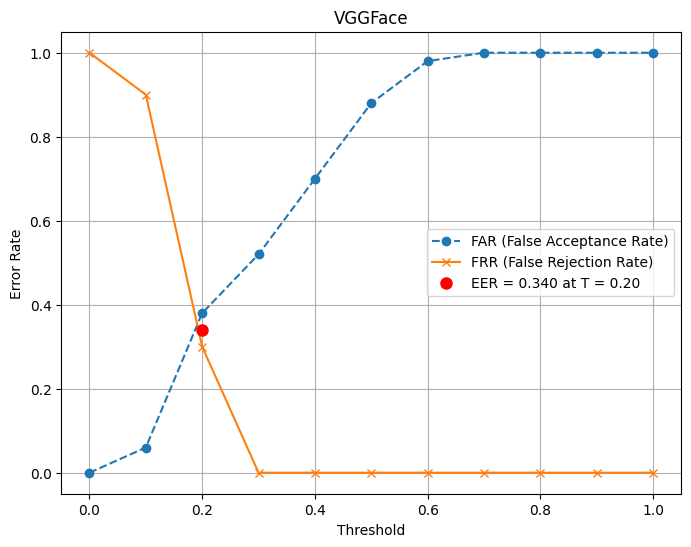

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


csv_path = "Dataset/Results/VGGFace_results.csv"
df = pd.read_csv(csv_path)

thresholds = np.sort(df['threshold'].unique())

far_list = []
frr_list = []

for thresh in thresholds:
    df_thresh = df[df['threshold'] == thresh]
    
    gt = df_thresh['gt'].values
    pred = df_thresh['prediction'].values

    fake_count = np.sum(gt == 1)
    false_accepts = np.sum((gt == 1) & (pred == 0))
    far = false_accepts / fake_count if fake_count > 0 else 0

    genuine_count = np.sum(gt == 0)
    false_rejects = np.sum((gt == 0) & (pred == 1))
    frr = false_rejects / genuine_count if genuine_count > 0 else 0

    far_list.append(far)
    frr_list.append(frr)

far_arr = np.array(far_list)
frr_arr = np.array(frr_list)

abs_diff = np.abs(far_arr - frr_arr)
eer_index = np.argmin(abs_diff)
eer_threshold = thresholds[eer_index]
eer_value = (far_arr[eer_index] + frr_arr[eer_index]) / 2  

print(f"EER: {eer_value:.3f} at threshold {eer_threshold:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, far_arr, label='FAR (False Acceptance Rate)', linestyle='--', marker='o')
plt.plot(thresholds, frr_arr, label='FRR (False Rejection Rate)', linestyle='-', marker='x')
plt.xlabel("Threshold")
plt.ylabel("Error Rate")
plt.title("VGGFace")
plt.grid(True)

plt.plot(eer_threshold, eer_value, 'ro', markersize=8, 
         label=f"EER = {eer_value:.3f} at T = {eer_threshold:.2f}")
plt.legend()

plt.show()

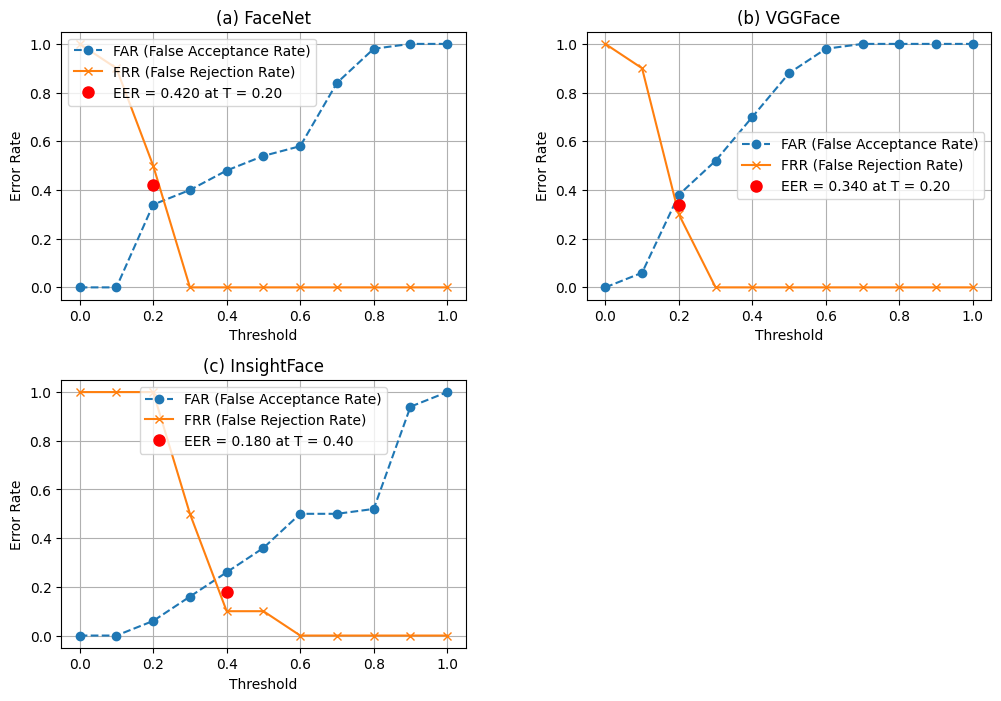

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths to CSV files for different face recognition systems
csv_paths = {
    "(a) FaceNet": "Dataset/Results/FaceNet_results.csv",
    "(b) VGGFace": "Dataset/Results/VGGFace_results.csv",
    "(c) InsightFace": "Dataset/Results/InsightFace_results.csv"
}

num_systems = len(csv_paths)

# Define subplot grid (always 2x2 for consistency)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten axes for easy indexing
axes = axes.flatten()

# Iterate over each system and plot its results
for i, (system, csv_path) in enumerate(csv_paths.items()):
    df = pd.read_csv(csv_path)
    thresholds = np.sort(df['threshold'].unique())

    far_list, frr_list = [], []

    for thresh in thresholds:
        df_thresh = df[df['threshold'] == thresh]
        
        gt = df_thresh['gt'].values  # Ground truth labels (1 = fake, 0 = genuine)
        pred = df_thresh['prediction'].values  # Predicted labels

        # Compute FAR & FRR
        fake_count = np.sum(gt == 1)
        false_accepts = np.sum((gt == 1) & (pred == 0))
        far = false_accepts / fake_count if fake_count > 0 else 0

        genuine_count = np.sum(gt == 0)
        false_rejects = np.sum((gt == 0) & (pred == 1))
        frr = false_rejects / genuine_count if genuine_count > 0 else 0

        far_list.append(far)
        frr_list.append(frr)

    far_arr = np.array(far_list)
    frr_arr = np.array(frr_list)

    # Compute EER (Equal Error Rate)
    abs_diff = np.abs(far_arr - frr_arr)
    eer_index = np.argmin(abs_diff)
    eer_threshold = thresholds[eer_index]
    eer_value = (far_arr[eer_index] + frr_arr[eer_index]) / 2  

    # Plot FAR and FRR for the system
    ax = axes[i]
    ax.plot(thresholds, far_arr, label='FAR (False Acceptance Rate)', linestyle='--', marker='o')
    ax.plot(thresholds, frr_arr, label='FRR (False Rejection Rate)', linestyle='-', marker='x')

    ax.set_xlabel("Threshold")
    ax.set_ylabel("Error Rate")
    ax.set_title(system)
    ax.grid(True)

    # Mark EER
    ax.plot(eer_threshold, eer_value, 'ro', markersize=8, 
            label=f"EER = {eer_value:.3f} at T = {eer_threshold:.2f}")
    
    ax.legend()

# Hide unused subplots (but keep layout consistent)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove extra subplots without resizing others

# Adjust layout to keep all plots the same size
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()
